In [1]:
import datetime
import math
import numpy as np
import pandas as pd

import networkx as nx
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

from haversine import haversine

# django postgresql api
from backend.fetch import fetch_parkings, fetch_demands_per_time_and_place, fetch_future_plan_history
from utils import fetch_demands_for_plot

# Plan Path

In [ ]:

REST_API_KEY = ""

def send_api_request(start, end, time):
    headers = {
        "Authorization": f"KakaoAK {REST_API_KEY}",
    }
    params = {
        "origin": f"{start[1]},{start[0]}",
        "destination": f"{end[1]},{end[0]}",
        "departure_time": f"{time}"
    }
    return requests.get(
        "https://apis-navi.kakaomobility.com/v1/future/directions",
        params=params,
        headers=headers
    )

In [40]:
# Read data
class BobuOptimizer():
  def __init__(
    self,
    provider_id,
    start_date,
    earnings_per_reservation,
    open_time = 7,
    close_time = 24,
    time_interval = 10,
    fuel_efficiency = 8,
    oil_price = 1700,
  ):
    # set params
    self.provider_id = provider_id
    self.start_date = start_date # "yyyymmdd"
    self.open_time = open_time # in hour
    self.close_time = close_time # in hour
    self.time_interval = time_interval # in minutes
    # 7:00 ~ 24:00 => 17 X 60 / 10 = 114
    self.time_levels =  (self.close_time - self.open_time) * 60 // self.time_interval

    # hyperparameter
    self.fuel_efficiency = fuel_efficiency # l/km
    self.oil_price = oil_price # won
    self.earnings_per_reservation = earnings_per_reservation # won

    # self.plan_route()

  def plan_route(self, ):
    # read data
    parkings = self._get_parkings()
    self.parkings = parkings
    self.n_parking = len(parkings)
    demands_per_time_and_place = self._get_demands_per_time_and_place()

    # make graph and plan route
    self._make_graph(demands_per_time_and_place)
    route = self._plan_path()
    self.route = route
    return route

  def _get_parkings(self):
    parking_place = fetch_parkings()
    parking_place = np.array(parking_place)
    return parking_place

  def _get_demands_per_time_and_place(self):
    return fetch_demands_per_time_and_place(
      self.provider_id,
      self.start_date
      )
    

  # Format data
  def _get_date_string(self, time_level):
      elapsed_time = time_level * self.time_interval
      now_hour = f"{self.open_time + elapsed_time // 60}"
      now_minute = f"{elapsed_time % 60}"
      now_time = self.start_date + ("0" if len(now_hour) < 2 else "") + now_hour + ("0" if len(now_minute) < 2 else "") + now_minute
      return now_time

  # utils
  def _encode_node(self, node, time_level):
    return self.n_parking * time_level + node

  def _decode_node(self, n):
    # returns node and time_level
    if n == -1:
      return (-1, -1)
    if n == -2:
      return (-1, self.time_levels)
    return (n % self.n_parking, n // self.n_parking)

  def _get_api_result(self, coord_i, coord_f, now_time, use_real_time_fetch = False):
    if not use_real_time_fetch:
      # Use prefetch data for all trucks
      return fetch_future_plan_history(coord_i, coord_f, now_time)
    else:
      # Send kakao mobility api request
      api_result = send_api_request(coord_i, coord_f, now_time).json()
      return {
          "distance": api_result['routes'][0]['summary']['distance'] , # in meters
          "duration": api_result['routes'][0]['summary']['duration'] # in seconds
      }

  def _get_traveling_time_level(self, minutes_spent):
    return max(int(math.ceil(minutes_spent // self.time_interval)), 1)

  def _get_fuel_cost_by_meter(self, distance):
    return distance / 1000 / self.fuel_efficiency * self.oil_price

  def _get_operationable_time_in_minute(self, traveling_time):
    return self.time_interval - traveling_time % self.time_interval

  def _get_partial_earnings_in_interval(
      self,
      demands_per_time_and_place,
      next_parking_id,
      traveling_time,
      curr_time_level,
      traveling_time_level
      ):
    operationable_time = self._get_operationable_time_in_minute(traveling_time)
    return (
        demands_per_time_and_place[curr_time_level + traveling_time_level, next_parking_id] *
        self.earnings_per_reservation * (operationable_time / self.time_interval)
    )

  def _make_graph(self, demands_per_time_and_place):
    mg = nx.DiGraph() # map graph
    ############## add node (each for time and place) ##########################
    for self.time_level in range(self.time_levels):
      for node in range(self.n_parking):
        mg.add_node(self._encode_node(node, self.time_level))
    mg.add_node(-1) # starting node
    mg.add_node(-2) # first starting node

    ############## add edge ####################################################

    # TODO: change weight to actual traveling time
    for node in range(self.n_parking):
      mg.add_edge(-1, node, weight = 0, operation_time = 0)
      mg.add_edge(self._encode_node(node, self.time_levels-1), -2, weight = 0, operation_time = 0)
    # with tqdm(total=self.time_levels * self.n_parking * self.n_parking) as pbar:
    for curr_time_level in range(self.time_levels-1):
      now_time = self._get_date_string(curr_time_level)
      for node in range(self.n_parking):
        # print(node, now_time)
        current_node = self._encode_node(node, curr_time_level)
        for next in range(self.n_parking):
          if node == next:
            next_node = self._encode_node(next, curr_time_level + 1)
            weight = - demands_per_time_and_place[curr_time_level + 1, next] * self.earnings_per_reservation
            mg.add_edge(current_node, next_node, weight=weight, operation_time = self.time_interval)
          else:
            api_result = self._get_api_result(
                (self.parkings[node][2], self.parkings[node][3]),
                (self.parkings[next][2], self.parkings[next][3]),
                now_time
            )
            traveling_time = api_result["duration"] // 60 # in minutes
            traveling_dist = api_result["distance"] # in meters

            traveling_time_level = self._get_traveling_time_level(traveling_time)
            if  curr_time_level + traveling_time_level >= self.time_levels: continue

            next_node = self._encode_node(next, curr_time_level + traveling_time_level)
            weight = (
                self._get_fuel_cost_by_meter(traveling_dist) -
                self._get_partial_earnings_in_interval(
                    demands_per_time_and_place,
                    next,
                    traveling_time,
                    curr_time_level,
                    traveling_time_level
                    )
                )
            operation_time = self._get_operationable_time_in_minute(traveling_time)
            mg.add_edge(current_node, next_node, weight=weight, operation_time = operation_time)
            # Add start time in node

    self.mg = mg
    return 0

  def _get_arrival_date_string(self, time_level, operation_time):
    elapsed_time = time_level * self.time_interval - operation_time
    now_hour = f"{self.open_time + elapsed_time // 60}"
    now_minute = f"{elapsed_time % 60}"
    now_time = self.start_date + ("0" if len(now_hour) < 2 else "") + now_hour + ("0" if len(now_minute) < 2 else "") + now_minute
    return now_time

  def _convert_path_to_route(self, path):
    route = []
    # stops = {"time", "address", "name", "latitude", "longitude"}
    idx = 0
    prev_parking_id = -1

    prev_node = -1
    for i, node in enumerate(path):
      if node in [-1, -2]: continue

      prev_node = path[i-1]
      parking_id, time_level = self._decode_node(node)
      prev_parking_id, prev_time_level = self._decode_node(prev_node)


      if parking_id == prev_parking_id: continue

      operation_time = int(self.mg.edges[prev_node, node]["operation_time"])
      arrival_time = self._get_arrival_date_string(time_level, operation_time)
      if prev_node != -1:
        # Add departure time
        departure_time = self._get_date_string(prev_time_level)
        route[-1]["departure_time"] = self._get_date_string(prev_time_level)

      route.append({
          "order": idx,
          "address": self.parkings[parking_id][0],
          "name": self.parkings[parking_id][1],
          "latitude": self.parkings[parking_id][2],
          "longitude": self.parkings[parking_id][3],
          "arrival_time": arrival_time
      })
      idx += 1
    route[-1]["departure_time"] = self.start_date + "2359"
    return route

  def _plan_path(self):
    path = nx.shortest_path(self.mg, source=-1, target=-2, weight='weight', method='bellman-ford')
    print(path)
    return self._convert_path_to_route(path)


# bt = BobuOptimizer()
# bt.plan_route()


In [41]:
bt = BobuOptimizer()
route = bt.plan_route(
  provider_id = "0",
  start_date="230901",
  earnings_per_reservation=1000
)

for stop in route:
  print(stop)

[-1, 16, 46, 76, 106, 136, 166, 196, 226, 256, 286, 316, 346, 376, 391, 421, 466, 496, -2]
{'order': 0, 'address': '서울시 중구 명동', 'name': '명동', 'latitude': 37.561299, 'longitude': 126.983174, 'arrival_time': '202309010700', 'departure_time': '202309011900'}
{'order': 1, 'address': '서울시 강남구 역삼동', 'name': '역삼 개나리 공원', 'latitude': 37.497785, 'longitude': 127.036187, 'arrival_time': '202309011947', 'departure_time': '202309012100'}
{'order': 2, 'address': '서울시 중구 명동', 'name': '명동', 'latitude': 37.561299, 'longitude': 126.983174, 'arrival_time': '202309012147', 'departure_time': '202309012359'}


# Plot data

In [24]:
def get_datetime_from_date_string(date_string):
  if int(date_string[8:10]) == 24:
    return datetime.datetime(
      int(date_string[0:4]),
      int(date_string[4:6]),
      int(date_string[6:8]),
      23,
      59,
      59
    )
  return datetime.datetime(
    int(date_string[0:4]),
    int(date_string[4:6]),
    int(date_string[6:8]),
    int(date_string[8:10]),
    int(date_string[10:12])
  )

def get_lat_long_time_form_route(route):
  latitude = []
  longitude = []
  time = []
  for p in route:
    # arrival point
    latitude.append(p["latitude"])
    longitude.append(p["longitude"])
    time.append(get_datetime_from_date_string(p["arrival_time"]))
    # departure point
    latitude.append(p["latitude"])
    longitude.append(p["longitude"])
    time.append(get_datetime_from_date_string(p["departure_time"]))
  return (np.array(latitude), np.array(longitude), np.array(time))

print(get_datetime_from_date_string("202309012400"))

2023-09-01 23:59:59


In [44]:
def update_rotation(num, ax):
    ax.view_init(elev=30, azim=num*4)
    return ax,

def plot_data_w_time_rotate(filename, route=None, save_gif = False, plot_on_colab=False):
    result = fetch_demands_for_plot( 
      provider_id = "0",
      start_date="230901"
      )
    x = np.array(result["longitude"])
    y = np.array(result["latitude"])
    z = np.array([t.timestamp() for t in result["time_start"]])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("long")
    ax.set_ylabel("lat")
    ax.set_zlabel("time_start")

    scatter = ax.scatter(x, y, z, c=z, s=5, alpha=0.5)

    if route:
      route_lat, route_long, route_time = get_lat_long_time_form_route(route)
      route_ts = np.array([t.timestamp() for t in route_time])
      plot = ax.plot(
          route_long,
          route_lat,
          route_ts,
          'rs'
          )

    ani = FuncAnimation(fig, update_rotation, frames=90, fargs=(ax,), repeat=True)

    if save_gif:
      writer = PillowWriter(fps=20)
      ani.save(filename+".gif", writer=writer)

    if plot_on_colab:
      # This is the part that makes it display on Colab
      return HTML(ani.to_jshtml())


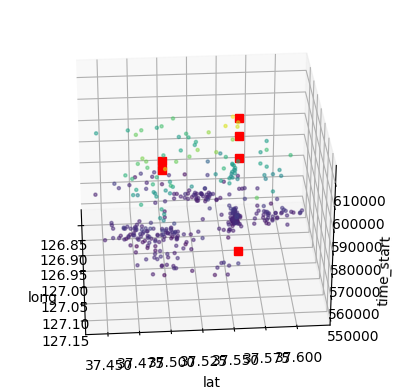

In [45]:
plot_data_w_time_rotate(filename="algorithm_demo", route=route, save_gif=True)